In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scstats
import os
import json
import statsmodels.api as sm

from dataclasses import dataclass
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.api.tsa.statespace import SARIMAX

# Time series and its integral

We start with a stationary time series $X$ and create its integral $Y$. We then attempt to get $X$ back from $Y$ by differentiating it. 

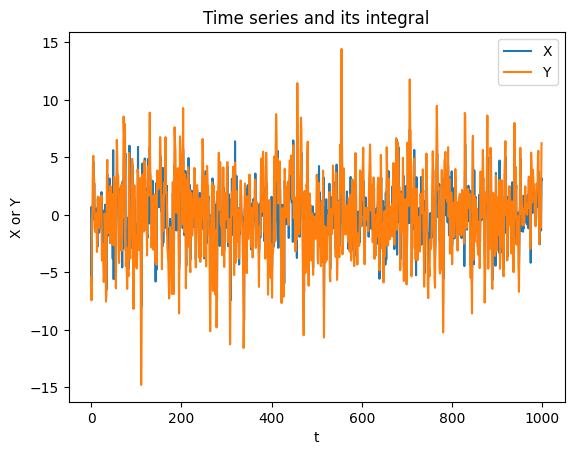

In [2]:
n_samples = 1000
rng = np.random.default_rng(12111842)
X = rng.normal(loc=0, scale=2.5, size=n_samples)
Y = [X[i] + X[i-1] for i in range(1, n_samples)]
T = [t for t in range(n_samples)]
plt.plot(T, X, label='X')
plt.plot(T[:-1], Y, label='Y')
plt.legend()
plt.xlabel('t')
plt.ylabel('X or Y')
_ = plt.title('Time series and its integral')

Integrating a time series introduces sharp peaks and troughs. Let us know find out if we can easily differentiate the series $Y$ and get $X$. We had
$$
\begin{eqnarray*}
Y[0] &=& X[1] + X[0] \\
Y[1] &=& X[2] + X[1] \\
&\vdots& \\
Y[N-1] &=& X[N] - X[N-1]
\end{eqnarray*}
$$
We obtained $Y$'s by adding consecutive terms. To go back, we must do the opposite.
$$
\begin{eqnarray*}
Y[1] - Y[0] &=& X[2] - X[0] \\
Y[2] - Y[1] &=& X[3] - X[1] \\
&\vdots& \\
Y[N-1] - Y[N-2] &=& X[N] - X[N-2]
\end{eqnarray*}
$$
so that, if we assume $X[0] = x_0, X[1] = x_1$ then
$$
\begin{eqnarray*}
X[2] &=& Y[1] - Y[0] + x_0 \\
X[3] &=& Y[2] - Y[1] + x_1 \\
X[4] &=& Y[3] - Y[2] + X[2] \\
&\vdots& \\
X[N] &=& Y[N-1] - Y[N-2] + X[N-2]
\end{eqnarray*}
$$


In [3]:
Yd = [Y[i+1] - Y[i] for i in range(len(Y) - 1)]
Xe = np.zeros(len(X))
Xe[0] = X[0]
Xe[1] = X[1]
for i in range(2, len(Xe)):
    Xe[i] = Yd[i-2] + Xe[i-2]

if any([np.abs(Xe[i] - X[i]) > 1e-8 for i in range(len(X))]):
    print('Some estimates differ.')
else:
    print('All estimates match')

All estimates match


# An illustration of pandas `diff` function

In [4]:
df = pd.DataFrame({'n': [n for n in range(10)], 
                   'nsq': [n**2 for n in range(10)], 
                   'ncu': [n**3 for n in range(10)]})

In [5]:
df

,n,nsq,ncu
0,0,0,0
1,1,1,1
2,2,4,8
3,3,9,27
4,4,16,64
5,5,25,125
6,6,36,216
7,7,49,343
8,8,64,512
9,9,81,729


In [6]:
df_1diff = pd.DataFrame({'n1d': df.n.diff(),
                         'nsq1d': df.nsq.diff(),
                         'ncu1d': df.ncu.diff()
                        })

In [7]:
df_1diff

,n1d,nsq1d,ncu1d
0,NaN,NaN,NaN
1,1.0,1.0,1.0
2,1.0,3.0,7.0
3,1.0,5.0,19.0
4,1.0,7.0,37.0
5,1.0,9.0,61.0
6,1.0,11.0,91.0
7,1.0,13.0,127.0
8,1.0,15.0,169.0
9,1.0,17.0,217.0


In [8]:
df_2diff = pd.DataFrame({'n2d': df_1diff.n1d.diff(),
                         'nsq2d': df_1diff.nsq1d.diff(),
                         'ncu2d': df_1diff.ncu1d.diff()
                        })

In [9]:
df_2diff

,n2d,nsq2d,ncu2d
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,0.0,2.0,6.0
3,0.0,2.0,12.0
4,0.0,2.0,18.0
5,0.0,2.0,24.0
6,0.0,2.0,30.0
7,0.0,2.0,36.0
8,0.0,2.0,42.0
9,0.0,2.0,48.0


This data should not be surprising. It follows from the discrete analogue of the derivatives of integer powers. It is interesting to plot the original data and its first and second differences.

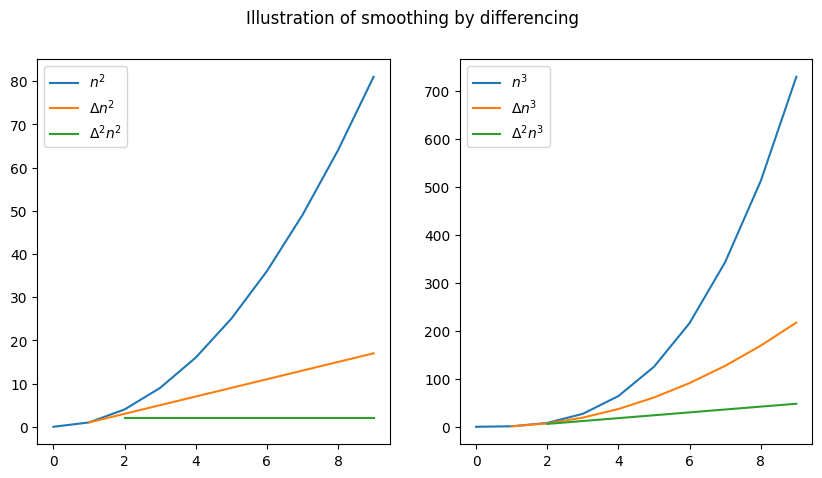

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(df.n, df.nsq, label=r'$n^2$')
ax[0].plot(df.n, df_1diff.nsq1d, label=r'$\Delta n^2$')
ax[0].plot(df.n, df_2diff.nsq2d, label=r'$\Delta^2 n^2$')
ax[0].legend()
ax[1].plot(df.n, df.ncu, label=r'$n^3$')
ax[1].plot(df.n, df_1diff.ncu1d, label=r'$\Delta n^3$')
ax[1].plot(df.n, df_2diff.ncu2d, label=r'$\Delta^2 n^3$')
ax[1].legend()
_ = plt.suptitle('Illustration of smoothing by differencing')

In [11]:
df_log = pd.DataFrame({'n': df.n[1:],
                       'nsq_log': np.log(df.nsq[1:]),
                       'ncu_log': np.log(df.ncu[1:])
                      })
df_log

,n,nsq_log,ncu_log
1,1,0.000000,0.000000
2,2,1.386294,2.079442
3,3,2.197225,3.295837
4,4,2.772589,4.158883
5,5,3.218876,4.828314
6,6,3.583519,5.375278
7,7,3.891820,5.837730
8,8,4.158883,6.238325
9,9,4.394449,6.591674


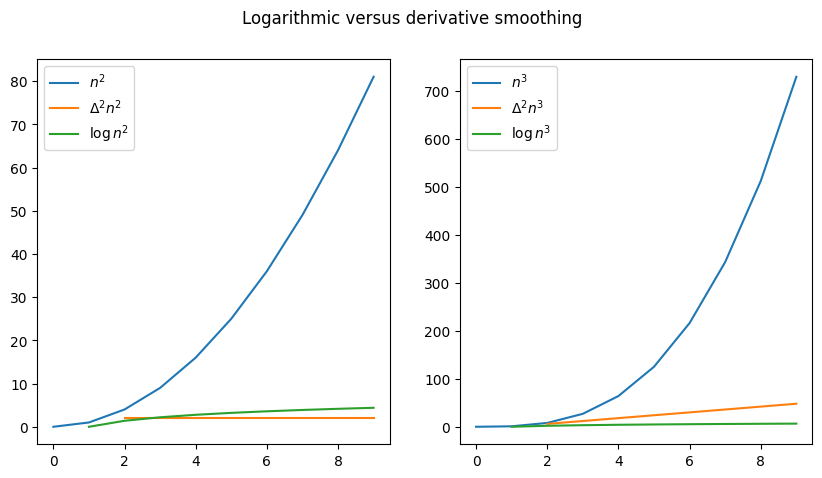

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(df.n, df.nsq, label=r'$n^2$')
ax[0].plot(df.n, df_2diff.nsq2d, label=r'$\Delta^2 n^2$')
ax[0].plot(df_log.n, df_log.nsq_log, label=r'$\log n^2$')
ax[0].legend()
ax[1].plot(df.n, df.ncu, label=r'$n^3$')
ax[1].plot(df.n, df_2diff.ncu2d, label=r'$\Delta^2 n^3$')
ax[1].plot(df_log.n, df_log.ncu_log, label=r'$\log n^3$')
ax[1].legend()
_ = plt.suptitle('Logarithmic versus derivative smoothing')

This shows that logarithmic smoothing is far more effective than differentiation, especially when we do not know the dominant power.

# A real time-series

In [13]:
filepath = os.path.join(
    os.environ['HOME'], 
    'repos/statistics/training/datasets', 
    'mean-monthly-temperature-1907-19.csv')

if os.path.exists(filepath):
    print('Data file exits.')
else:
    print('Could not find the data.')

Data file exits.


## Prepare the data

In [14]:
monthly_tmpr = pd.read_csv(filepath,
                           header=0,
                           skipfooter=2,
                           engine='python', # Needed to skip footer
                           names=['month', 'tmpr'])
monthly_tmpr['fdom'] = monthly_tmpr['month'].apply(lambda m: datetime.strptime(m, '%Y-%m'))  
monthly_tmpr.drop('month', axis=1, inplace=True)
monthly_tmpr.set_index(pd.DatetimeIndex(monthly_tmpr.fdom), inplace=True)
monthly_tmpr.drop('fdom', axis=1, inplace=True)
monthly_tmpr.index.freq = 'MS'

In [15]:
annual_tmpr = monthly_tmpr.resample('YE').mean() # Mean annual temperature

## Visualise the data

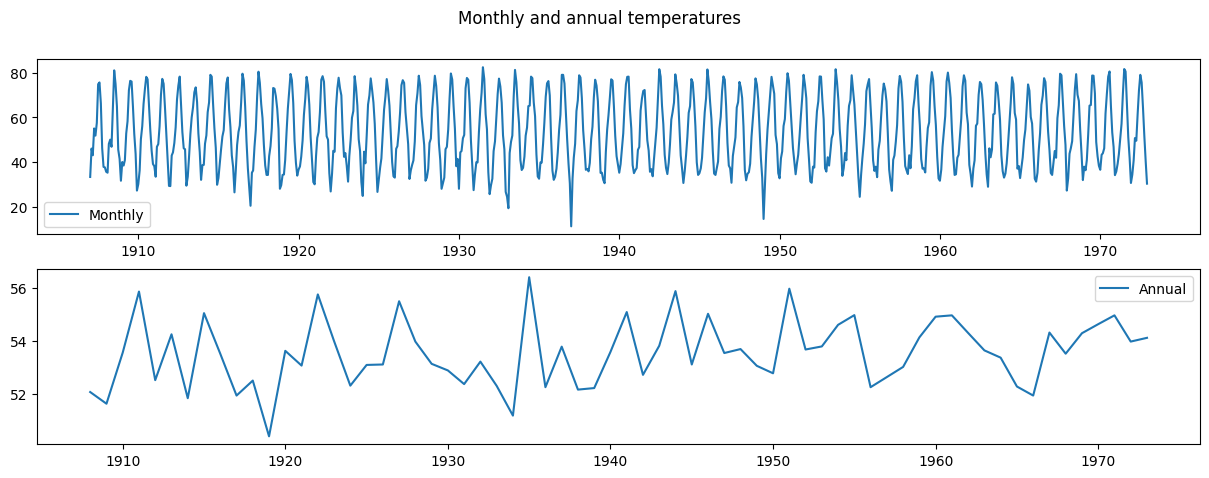

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].plot(monthly_tmpr, label='Monthly')
ax[0].legend()
ax[1].plot(annual_tmpr, label='Annual')
ax[1].legend()
_ = plt.suptitle('Monthly and annual temperatures')

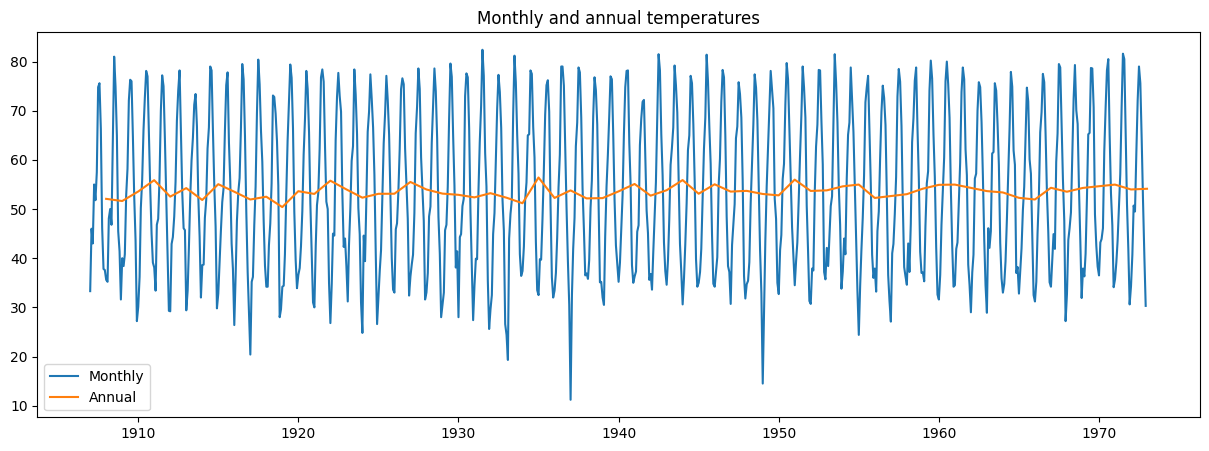

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_tmpr, label='Monthly')
plt.plot(annual_tmpr, label='Annual')
plt.legend(loc='lower left')
_ = plt.title('Monthly and annual temperatures')


The plot clearly shows that the variations in annual mean temperatures are far lesser than the monthly temperatures.

## Augmented Dickey-Fuller test

In [18]:
@dataclass
class DFTestResults():
    testStatistic: np.float64
    pvalue: np.float64
    nLags: int
    nObs: int
    criticalVals: str
    icbest: float

    def __init__(self, testStatistic, pvalue, nLags, nObs, criticalVals, icbest):
        self.testStatistic = testStatistic
        self.pvalue = pvalue
        self.nLags = nLags
        self.nObs = nObs
        self.criticalVals = json.dumps(criticalVals)
        self.icbest = icbest

    def isStationary(self, significance: float=0.05) -> bool:
        return self.pvalue < significance

In [19]:
res = adfuller(monthly_tmpr)
adres_monthly = DFTestResults(res[0], res[1], res[2], res[3], res[4], res[5])
res = adfuller(annual_tmpr)
adres_annual = DFTestResults(res[0], res[1], res[2], res[3], res[4], res[5])

In [20]:
if adres_monthly.isStationary():
    print('Monthly time series is not non-stationary.')
else:
    print('Annual time series is non-stationary.')

if adres_annual.isStationary():
    print('Annual time series is not non-stationary.')
else:
    print('Annual time series is non-stationary.')

Monthly time series is not non-stationary.
Annual time series is not non-stationary.


In [38]:
def show_ts(X: pd.core.frame.Series, lags: int=None) -> None:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(X, label='Raw signal')
    ax[0].set_title('Raw signal')
    _ = plot_acf(x=X, ax=ax[1], lags=lags)
    _ = plot_pacf(x=X, ax=ax[2], lags=lags)
    _ = plt.suptitle('Raw signal and correlation functions')

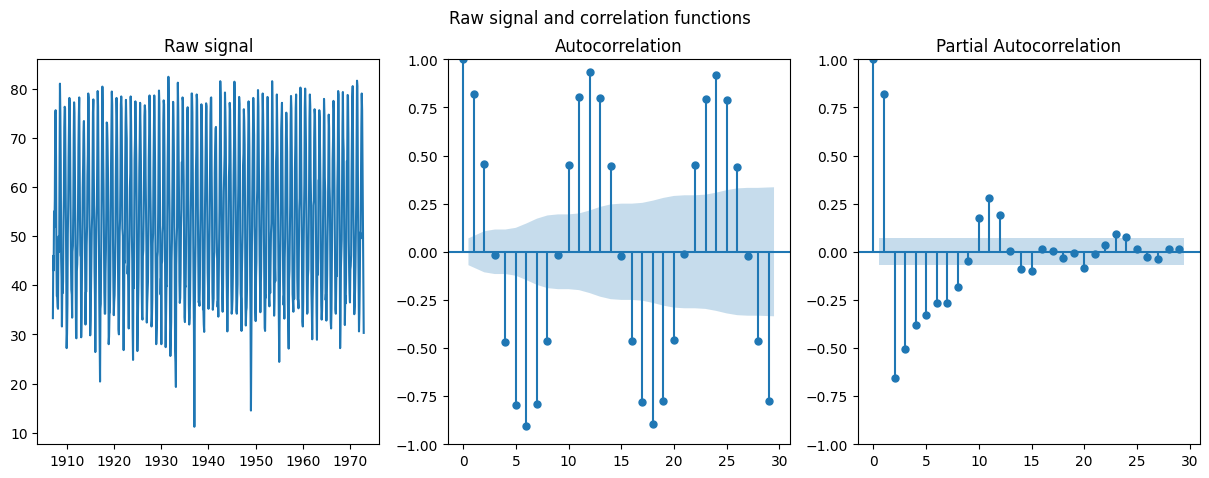

In [39]:
show_ts(monthly_tmpr)

In [53]:
res_sarimax_monthly = sm.tsa.statespace.SARIMAX(monthly_tmpr.tmpr, 
                                                order=(1,0,0), 
                                                seasonal_order=(0, 1, 1, 12)
                                               ).fit(method='cg')

Optimization terminated successfully.
         Current function value: 2.690227
         Iterations: 30
         Function evaluations: 57
         Gradient evaluations: 57


In [54]:
res_sarimax_monthly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 tmpr   No. Observations:                  792
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -2750.615
Date:                              Wed, 08 Jan 2025   AIC                           5507.229
Time:                                      19:37:48   BIC                           5521.207
Sample:                                  01-01-1907   HQIC                          5512.606
                                       - 12-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1815      0.288     -0.630      0.529      -0.746       0.383
ma.S.L12      -0.7108      0.235     -3.030      0.002      -1.170      -0.251
sigma2       163.7779     12.942     12.655      0.000     138.412     189.144
===================================================================================
Ljung-Box (L1) (Q):                  95.05   Jarque-Bera (JB):               161.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

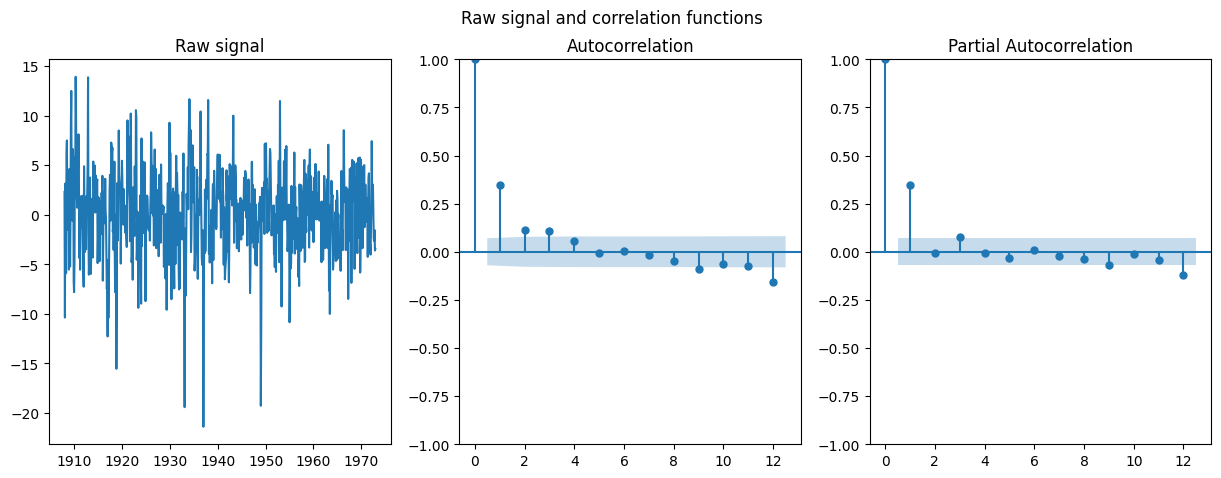

In [56]:
show_ts(res_sarimax_monthly.resid[res_sarimax_monthly.loglikelihood_burn:], lags=12)

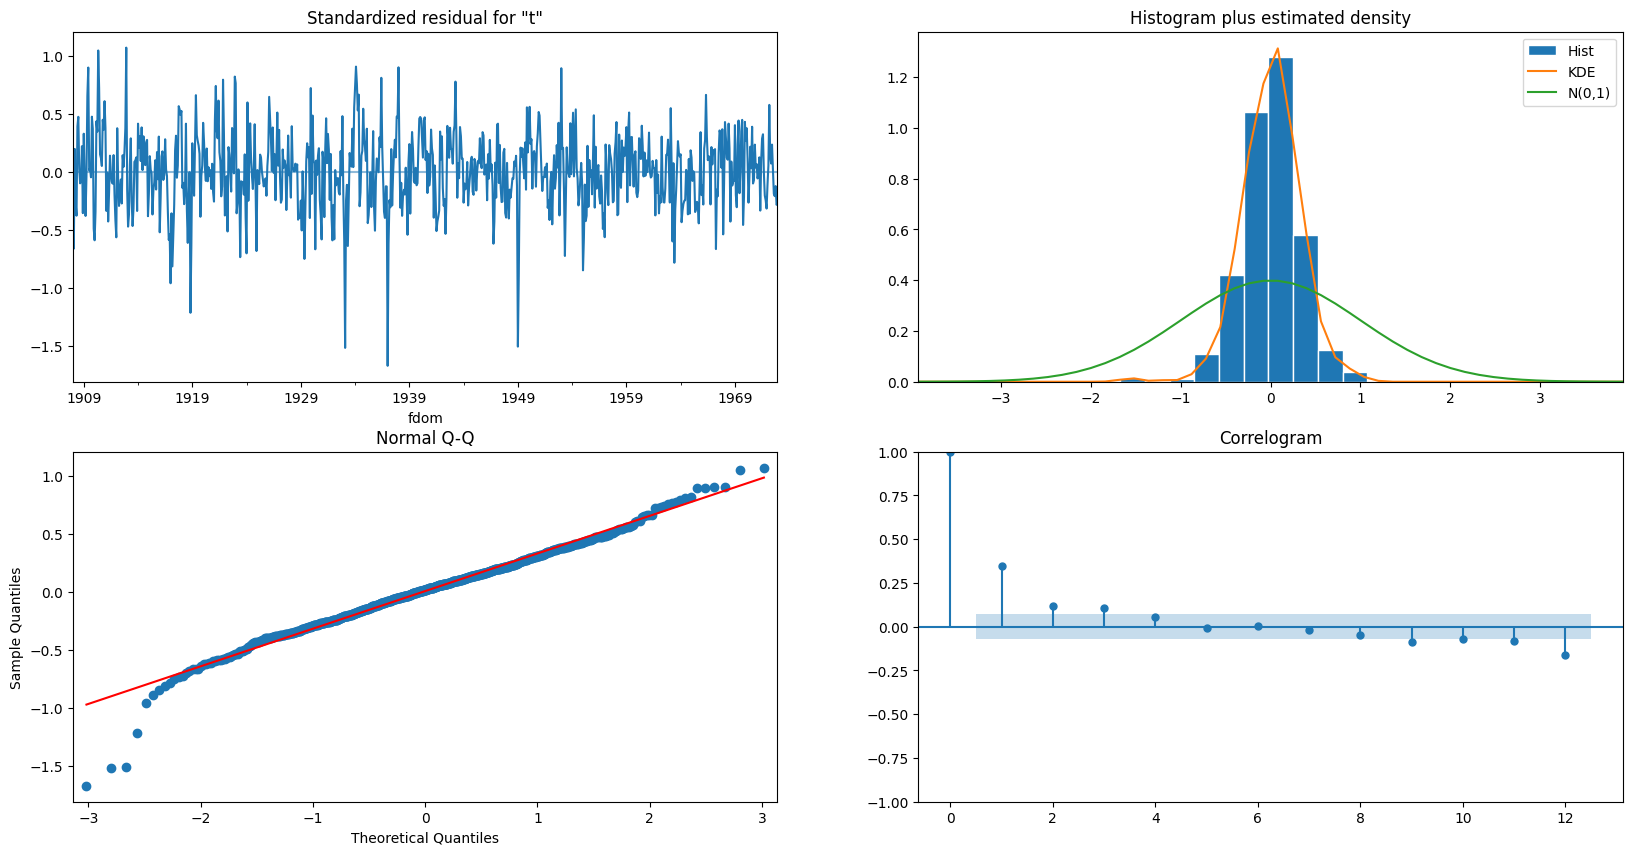

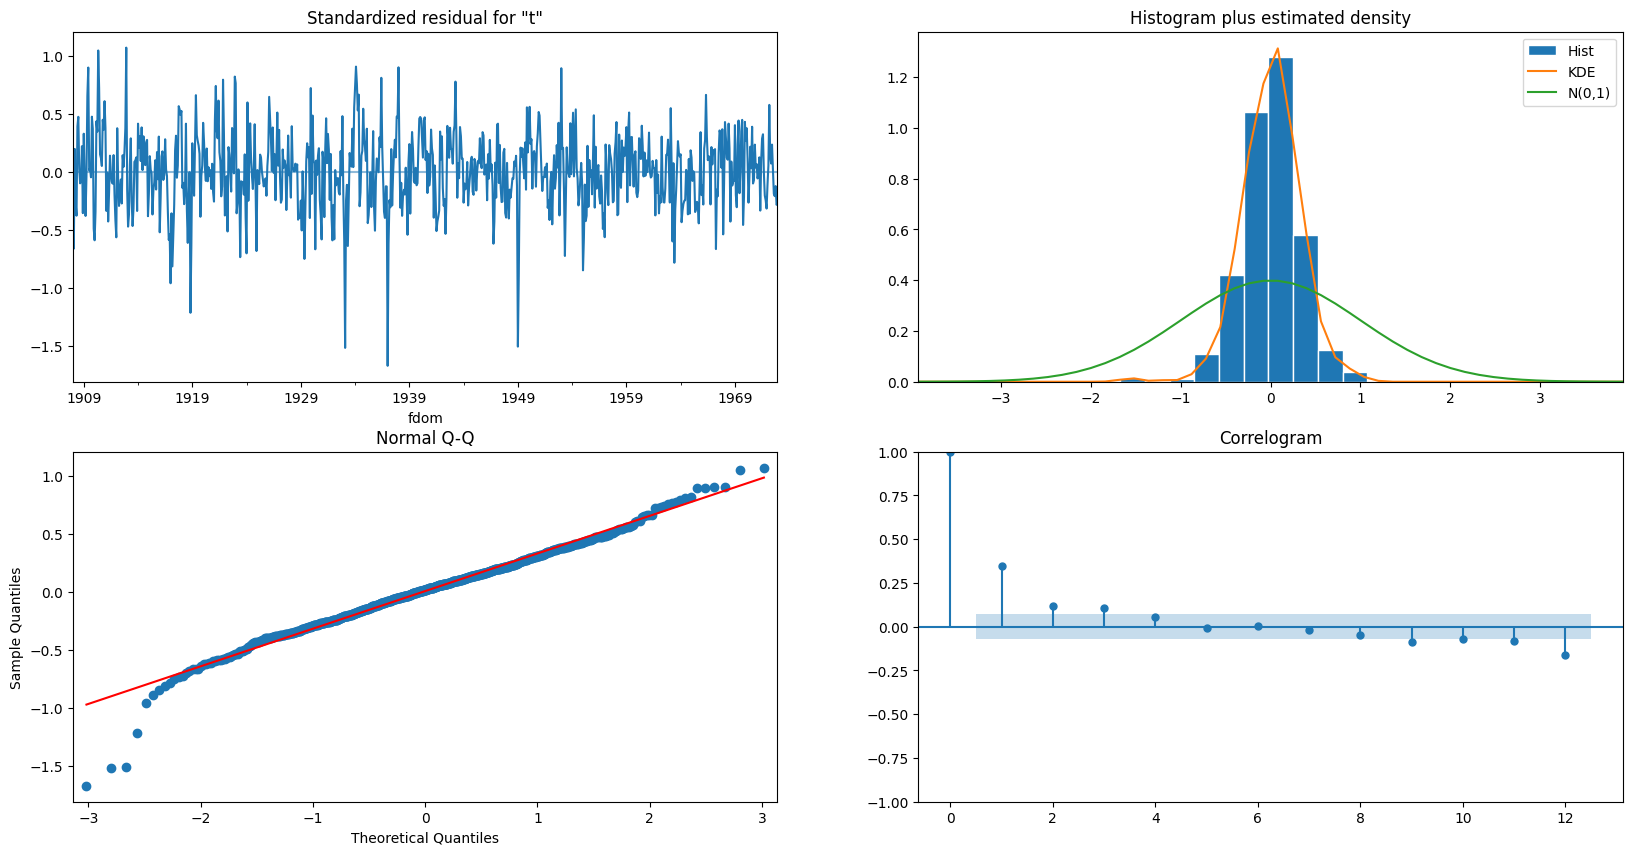

In [57]:
res_sarimax_monthly.plot_diagnostics(lags=12, figsize=(20, 10))

<Axes: xlabel='fdom'>

<Figure size 1500x500 with 0 Axes>

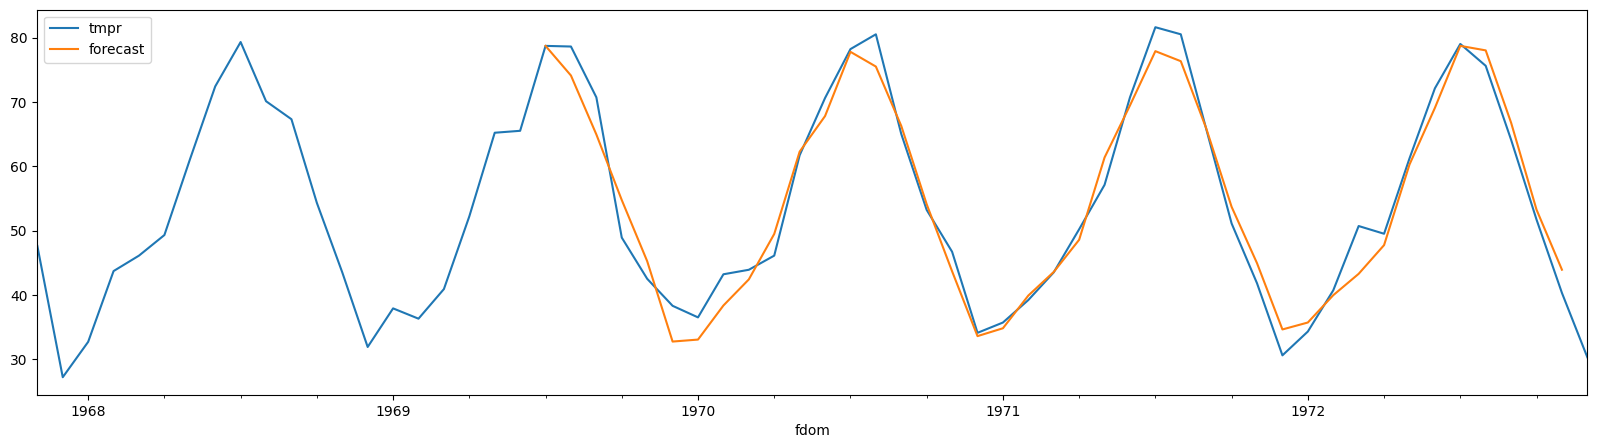

In [61]:
monthly_tmpr['forecast'] = res_sarimax_monthly.predict(start=750, end=790)
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(15, 5))
_ = monthly_tmpr[730:][['tmpr', 'forecast']].plot(figsize=(20, 5))

The forecast doesn't seem to be awfully off.